In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from biopsykit.utils.dataframe_handling import multi_xs
import biopsykit as bp

In [3]:
import sklearn.metrics as sk_metrics
from sklearn.metrics import confusion_matrix, matthews_corrcoef

from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, precision_score, recall_score, cohen_kappa_score, matthews_corrcoef
from sleep_analysis.classification.deep_learning.dl_scoring import dl_multiclass_specificity

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from fau_colors import register_cmaps

register_cmaps()

sns.set_theme(context="talk", style="white", palette="faculties_light", font_scale=1.2)

%matplotlib widget

In [6]:
from sleep_analysis.datasets.d04_main_dataset_control import D04MainStudy

In [7]:
dataset_retrain = D04MainStudy(classification="5stage", retrain = True)
dataset_retrain = dataset_retrain.get_subset(subj_id=["18","19","22","28","34", "38","40","44"])
vp_40_retrain = dataset_retrain[6]

In [8]:
dataset_rad_only = D04MainStudy(classification="5stage", retrain = False)
dataset_rad_only = dataset_rad_only.get_subset(subj_id=["18","19","22","28","34", "38","40","44"])
vp_40_rad_only = dataset_rad_only[6]

In [9]:
vp_40_retrain

,subj_id
0,40


In [10]:
vp_40_rad_only

,subj_id
0,40


In [38]:
pred_transfer_learning = vp_40_retrain.classification_labels
pred_rad_only= vp_40_rad_only.classification_labels
ground_truth = vp_40_retrain.ground_truth[["5stage"]]

In [39]:
def change_ylabels_somnogram(df):
    df[df==0] = "Wake"
    df[df==1] = "N1"
    df[df==2] = "N2"
    df[df==3] = "N3"
    df[df==4] = "REM"
    
    df[df=="N3"] = 0
    df[df=="N2"] = 1
    df[df=="N1"] = 2
    df[df=="REM"] = 3
    df[df=="Wake"] = 4
    return df    


In [40]:
ground_truth = change_ylabels_somnogram(ground_truth)
pred_rad_only = change_ylabels_somnogram(pred_rad_only)
pred_transfer_learning = change_ylabels_somnogram(pred_transfer_learning)

/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_45138/395865629.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Wake' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df==0] = "Wake"
/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_45138/395865629.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Wake' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df==0] = "Wake"
/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_45138/395865629.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Wake' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df==0] = "Wake"


In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_polysomnogram(ground_truth, radar_predictions, transfer_learning_predictions, subject_id):
    """
    Plots the polysomnogram with ground truth, radar-only classification, and transfer learning classification.
    Highlights regions where the transfer learning approach improved the classification using background colors.
    
    Parameters:
    - ground_truth (pd.DataFrame): DataFrame with ground truth sleep stages indexed by time.
    - radar_predictions (pd.DataFrame): DataFrame with radar-only model predictions indexed by time.
    - transfer_learning_predictions (pd.DataFrame): DataFrame with transfer learning model predictions indexed by time.
    - subject_id (str): Identifier for the subject being plotted.
    """
    # Merge data
    data = ground_truth.merge(radar_predictions, left_index=True, right_index=True, suffixes=("_true", "_radar"))
    data = data.merge(transfer_learning_predictions, left_index=True, right_index=True)
    data.rename(columns={data.columns[-1]: "transfer_pred"}, inplace=True)
    data.rename(columns={"0_x": "Radar"}, inplace=True)
    
    # Identify regions where transfer learning improved classification
    data["improved"] = (data["transfer_pred"] == data["5stage"]) & (data["Radar"] != data["5stage"])
    improvement_starts = data.index[(data["improved"] & ~data["improved"].shift(1).fillna(False))]
    improvement_ends = data.index[(data["improved"] & ~data["improved"].shift(-1).fillna(False))]

    # Identify regions where transfer learning worsened classification
    data["worsened"] = (data["transfer_pred"] != data["5stage"]) & (data["Radar"] == data["5stage"])
    worsening_starts = data.index[(data["worsened"] & ~data["worsened"].shift(1).fillna(False))]
    worsening_ends = data.index[(data["worsened"] & ~data["worsened"].shift(-1).fillna(False))]
    
    
    # Set up figure
    fig, ax = plt.subplots(figsize=(20, 6))
    
    # Highlight improvement regions (only add label once)
    first_improvement = True
    for start, end in zip(improvement_starts, improvement_ends):
        ax.axvspan(start, end, color='lightgreen', alpha=0.3, label='Improvement Region' if first_improvement else "")
        first_improvement = False
    
    # Highlight worsening regions (only add label once)
    first_worsening = True
    for start, end in zip(worsening_starts, worsening_ends):
        ax.axvspan(start, end, color='red', alpha=0.3, label='Worsened Region' if first_worsening else "")
        first_worsening = False
    
    
    # Plot sleep stages
    ax.plot(data.index, data['5stage'], label='Ground Truth', color='blue', alpha=0.6, linestyle='-')
    ax.plot(data.index, data['Radar'], label='Radar Prediction', color='gray', alpha=0.6, linestyle='--')
    ax.plot(data.index, data['transfer_pred'], label='Transfer Learning Prediction', color='red', alpha=0.6, linestyle='--')
    
    # Formatting
    ax.set_ylabel("Sleep Stage")
    ax.set_yticks([0, 1, 2, 3, 4])
    ax.set_yticklabels(["N3", "N2", "N1", "REM", "Awake"])

    
    # Format x-axis to show only HH:MM
    ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    
    # Move legend outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title(f"Hypnogram: Sleep Stages for Participant {subject_id}")
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    plt.savefig(subject_id + "_somnogram.pdf",bbox_inches="tight",
)
# Example usage:
# plot_polysomnogram(ground_truth_df, radar_predictions_df, transfer_learning_predictions_df, subject_id="001")

/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_45138/2952285035.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  improvement_starts = data.index[(data["improved"] & ~data["improved"].shift(1).fillna(False))]
/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_45138/2952285035.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  improvement_ends = data.index[(data["improved"] & ~data["improved"].shift(-1).fillna(False))]
/var/folders/kr/z18bsf7n4xsf9cd__hgnn7lh0000gn/T/ipykernel_45138/2952285035.py:29: FutureWarning: Downcasting obj

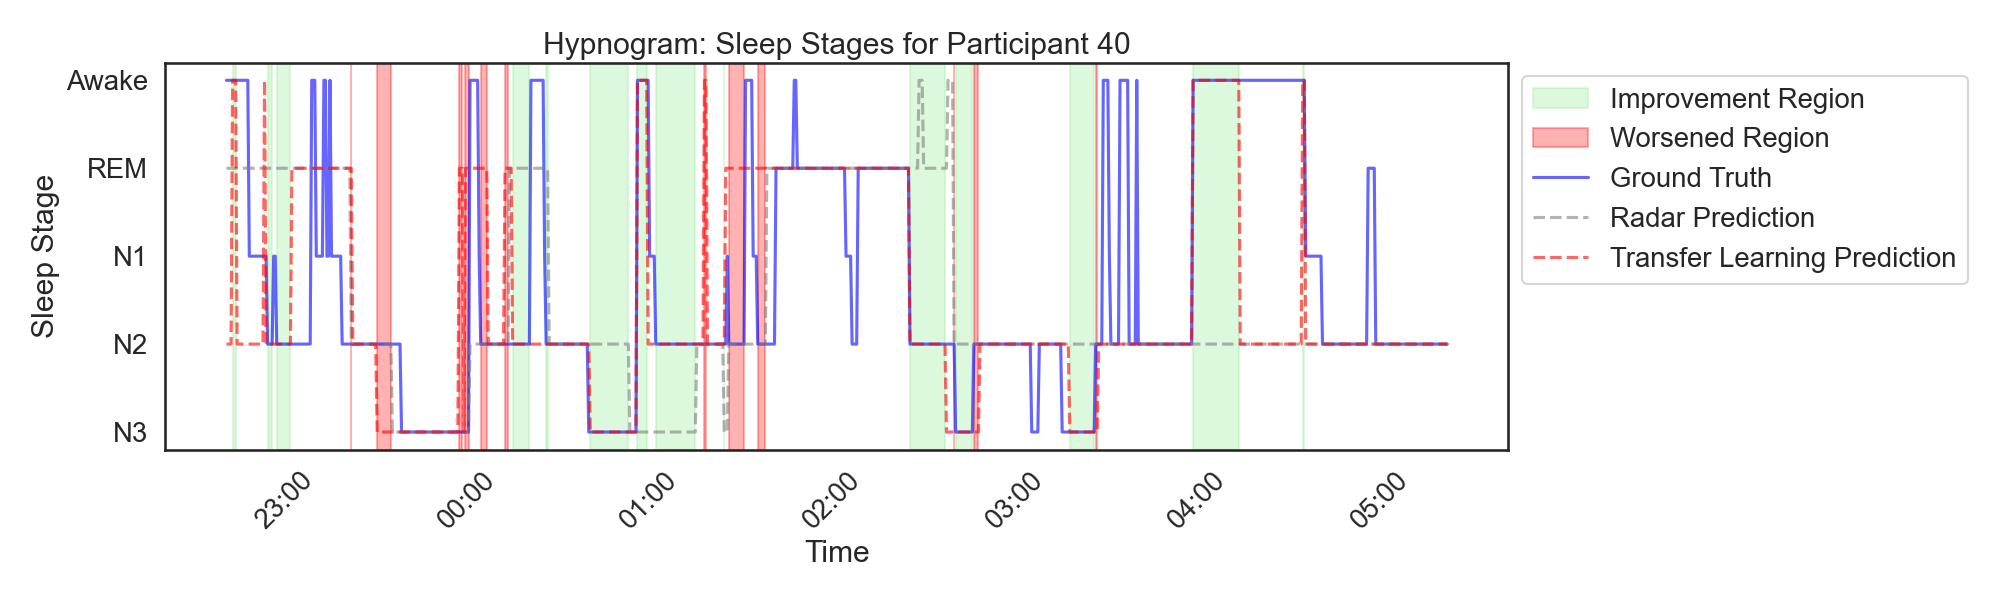

In [46]:
plot_polysomnogram(ground_truth, pred_rad_only, pred_transfer_learning, subject_id="40")